In [30]:
from PIL import Image
from torchvision import datasets, transforms
import torch.nn as nn
import torch
from matplotlib import pyplot as plt
import torch.optim as optim

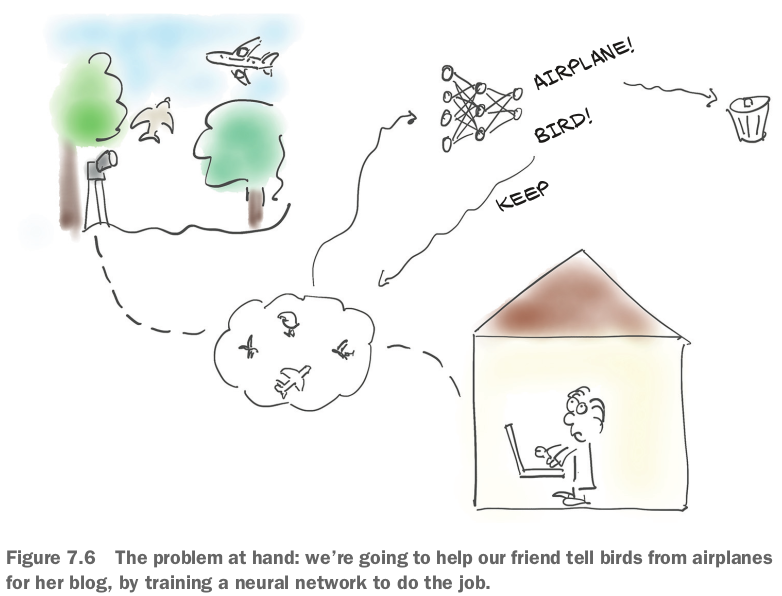

In [2]:
Image.open('img/tell-bird-from-airplane-2020-12-27-10-15-05.png')

### 7.2.1 Building the dataset
- cifar10からbird, airplaneのみのデータセットを作る：

In [16]:
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))
                          ]))
# 上記のmean, stdはtrain datasetから計算したが、valにも使われている：
# https://github.com/youngsend/dlwpt-code/blob/master/p1ch7/2_birds_airplanes.ipynb
cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                       (0.2470, 0.2435, 0.2616))
                              ]))

In [17]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
         for img, label in cifar10
         if label in [0, 2]]
cifar2_val = [(img, label_map[label])
             for img, label in cifar10_val
             if label in [0, 2]]

- The `cifar2` object satisfies the basic requirements for a `Dataset` - that is, `__len__` and `__getitem__` are defined.
    - However, we might wish to implement a proper `Dataset` if we hit limitations with it.
    
### 7.2.2 A fully connected model
- In theory if we just take the image pixels and straighten them into a long 1D vector, we could consider those numbers as input features:

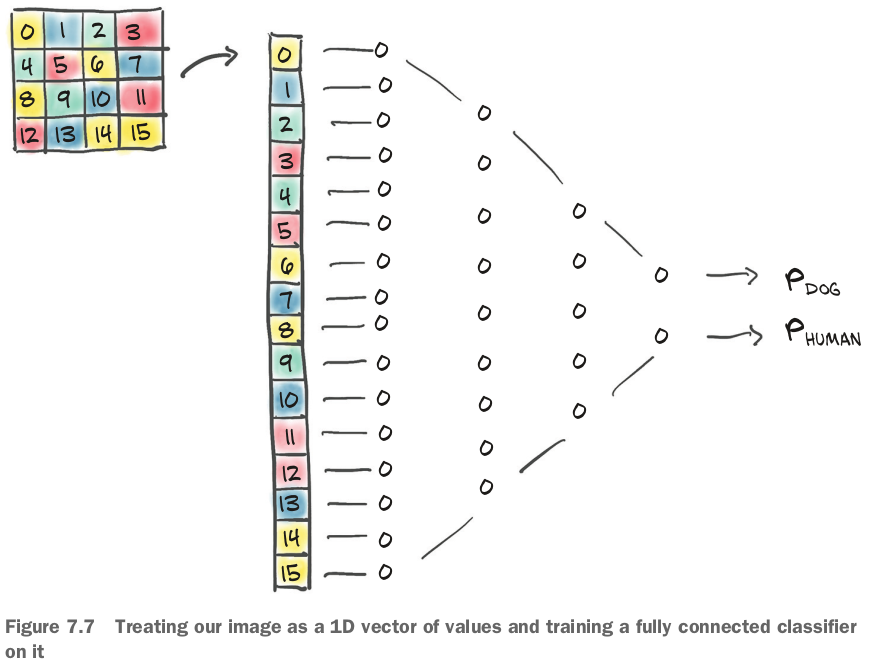

In [6]:
Image.open('img/treat-image-as-1d-vector-2020-12-27-10-34-09.png')

In [9]:
n_out = 2

# 3072 = 32 * 32 * 3
model = nn.Sequential(nn.Linear(3072, 512),
                     nn.Tanh(),
                     nn.Linear(512, n_out))

### 7.2.3 Output of a classifier
- Using distance on the "probability" vectors would already have been much better than using `MSELoss` with the class numbers - which **does not make sense for categories and does not work at all in practice**.
- For the special binary classification case, using two values here is redundant.
    - And indeed PyTorch lets us output only a single probability using the `nn.Sigmoid` activation at the end of the model to get a probability and the binary cross-entropy loss function `nn.BCELoss`.
    - なるほど！：There also is **an `nn.BCELossWithLogits` merging these two steps**.
- labelなので、one-hot-encodingにしましょう！だから理想的にはthe network would output `torch.tensor([1.0, 0.0])` for an airplane and `torch.tensor([0.0, 1.0])` for a bird.
    - The key realization in this case is that **we can interpret our output as probabilities: the first entry is the probability of "airplane", and the second is the probability of "bird"**.
- 確率として解釈するのはまた２つ要求がでる：each element of the output must be in the `[0.0, 1.0]` range; **the elements of the output must add up to 1.0**.
- It sounds like a tough constraint to enforce **in a differentiable way** on a vector of numbers. 大丈夫！softmax!

### 7.2.4 Representing the output as probabilities
- Softmax:

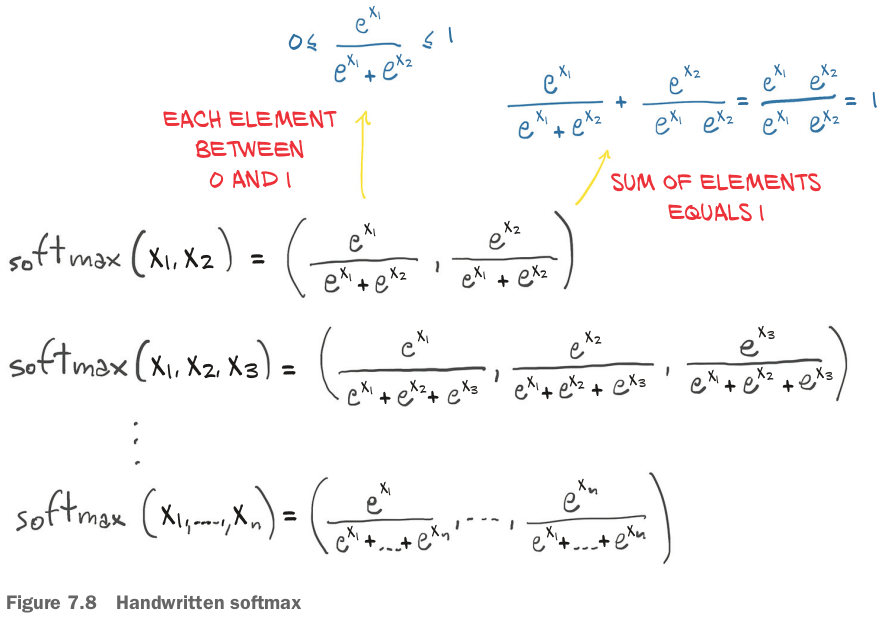

In [10]:
Image.open('img/softmax-2020-12-27-10-55-45.png')

In [11]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [12]:
x = torch.tensor([1.0, 2.0, 3.0])
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

- Softmax is a monotone (単調) function, but **not scale invariant**, in that **the ratio between values is not preserved**. 指数だもん。
    - **This is not a real issue, since the learning process will drive the parameters of the model in a way that values have appropriate ratios**.

In [13]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                 [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

- 上記の`dim=1`は時々理解しにくい。一見でrowの方向で計算しているけど、rowは0じゃない？でもこのxのshapeは(2, 3)だ。3に対してsoftmaxを計算しているでしょう。だからdim=1でしょう。
- Add a softmax at the end of our model, and our network will be equipped to produce probabilities:

In [14]:
model = nn.Sequential(nn.Linear(3072, 512),
                     nn.Tanh(),
                     nn.Linear(512, 2),
                     nn.Softmax(dim=1))

- まだ学習してないけど、このモデルを使ってみましょう：

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


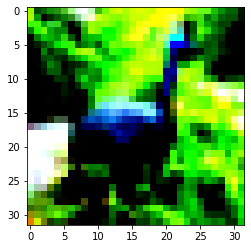

In [20]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

- Turn our 3x32x32 image into a 1D tensor and then add an extra dimension in the zeroth position:

In [21]:
img_batch = img.view(-1).unsqueeze(0)

In [22]:
out = model(img_batch)
out

tensor([[0.3732, 0.6268]], grad_fn=<SoftmaxBackward>)

In [23]:
_, index = torch.max(out, dim=1)
index

tensor([1])

### 7.2.5 A loss for classifying
- We could still use MSE and make our output probabilities converge to `[0.0, 1.0]` and `[1.0, 0.0]`.
    - However, thinking about it, **we're not really interested in reproducing these values exactly**.
    - In other words, we **want to penalize misclassifications rather than painstakingly (労「ろう」を惜しまず) penalize everything that doesn't look exactly like a 0.0 and 1.0**.
- **negative log likelihood**: `NLL = - sum (log(out_i[c_i]))`.
    - Where **the sum is taken over *N* samples and `c_i` is the correct class for sample *i***:

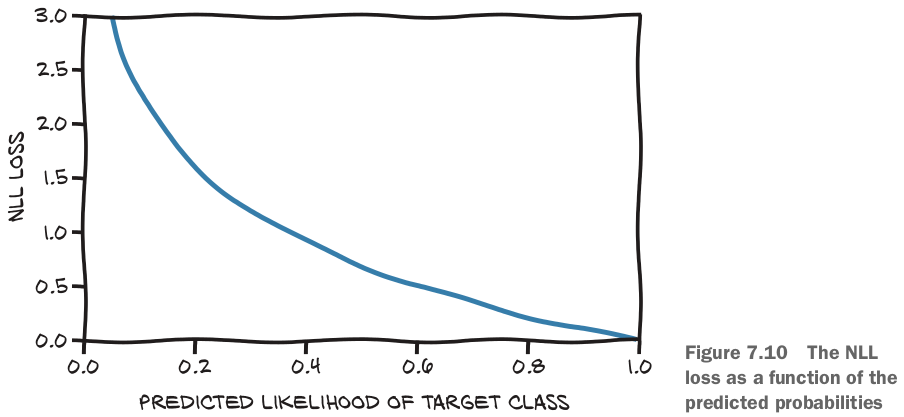

In [24]:
Image.open('img/negative-log-likelihood-2020-12-27-15-13-51.png')

- `nn.NLLLoss` **does not take probabilities but rather take a tensor of log probabilities as input**.
    - There's a good reason behind the input convention: taking the logarithm of a probability is tricky when the probability gets close to zero.
    - The workaround is to **use `nn.LogSoftmax` instead of `nn.Softmax`**, which takes care to make the calculation numerically stable:

In [27]:
model = nn.Sequential(nn.Linear(3072, 512),
                     nn.Tanh(),
                     nn.Linear(512, 2),
                     nn.LogSoftmax(dim=1))
loss = nn.NLLLoss()

In [28]:
img, label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(0.4345, grad_fn=<NllLossBackward>)

- How using cross-entropy loss improves over MSE:

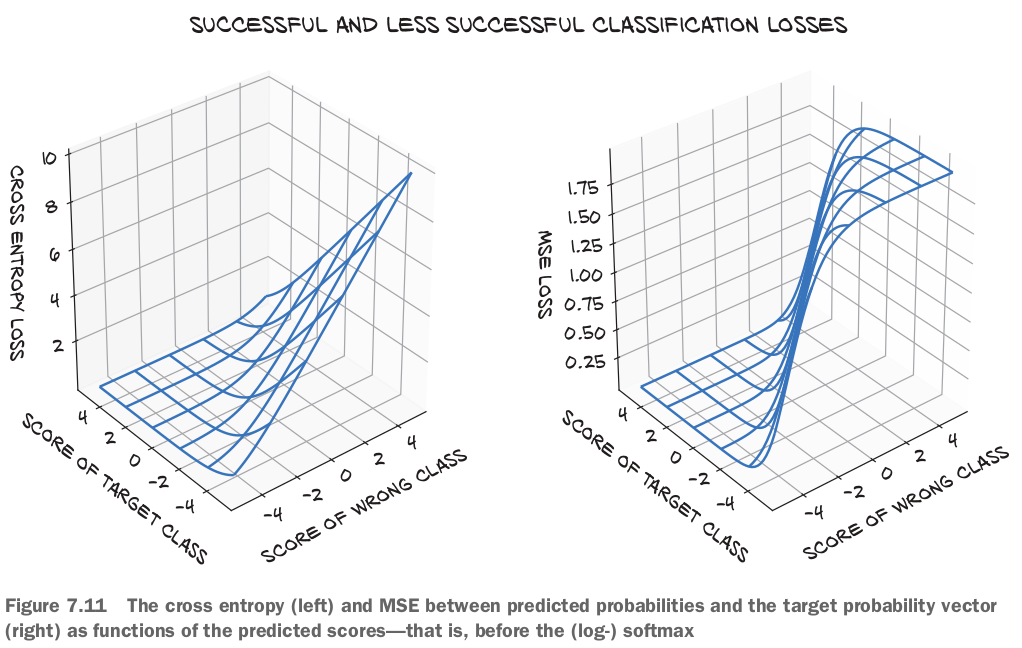

In [29]:
Image.open('img/cross-entropy-vs-mse-2020-12-27-15-32-00.png')

- The cross-entropy loss has some slope when the prediction is off target, while the MSE **saturates much earlier and - crucially - also for very wrong predictions**.
    - The underlying reason is that the **slope of the MSE is too low to compensate for the flatness of the softmax function for wrong predictions**.
    
### 7.2.6 Training the classifier

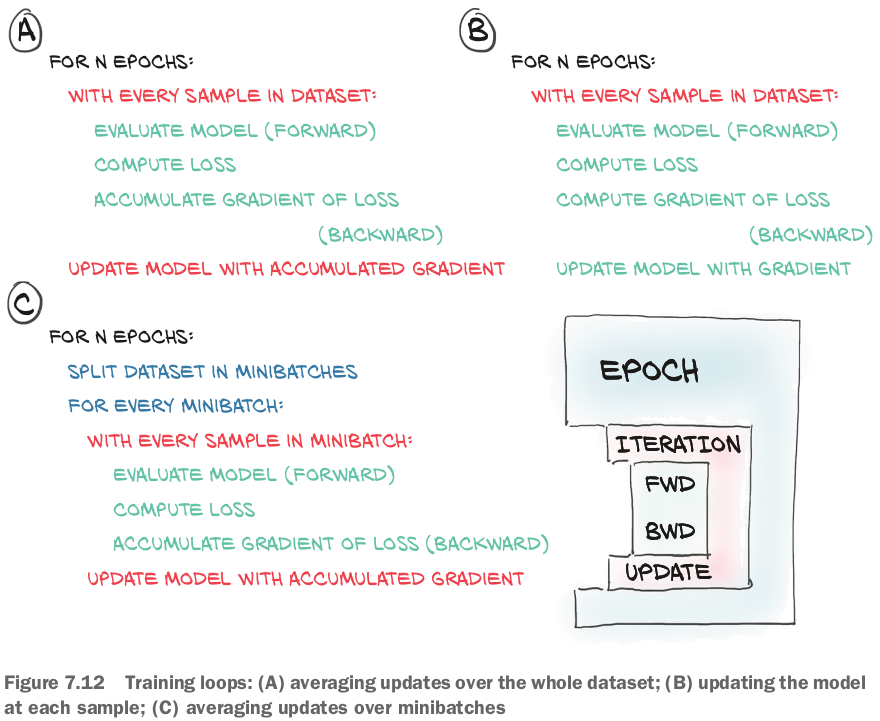

In [33]:
Image.open('img/training-loop-3-ways-2020-12-27-15-53-03.png')

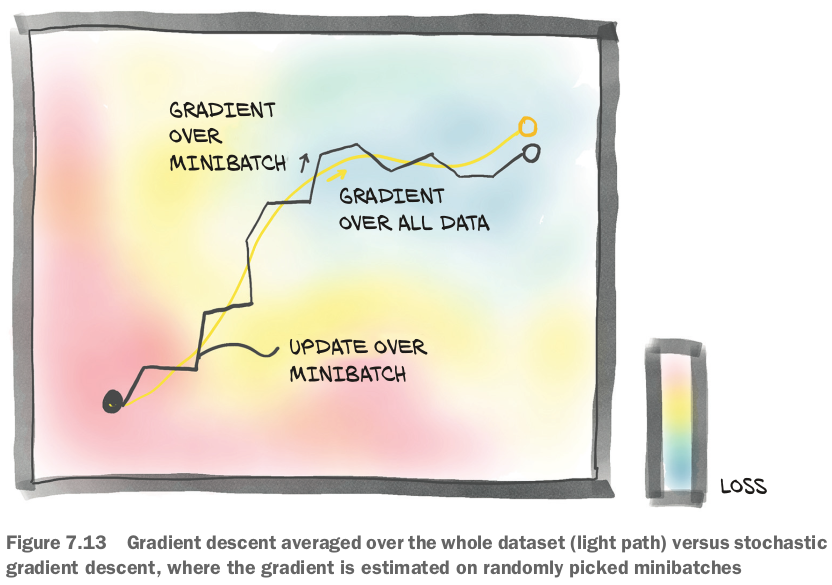

In [34]:
Image.open('img/whole-gradient-descent-vs-stochastic-gradient-descent-2020-12-27-15-58-16.png')

- Gradients from minibatches are **randomly off the ideal trajectory**, which is **part of the reason why we want to use a reasonably small learning rate**.
- **Shuffling the dataset at each epoch** helps ensure that the sequence of gradients estimated over minibatches is **representative** of the gradients computed across the full dataset.
- The `torch.utils.data` module has a class that helps with shuffling and organizing the data in minibatches: `DataLoader`:

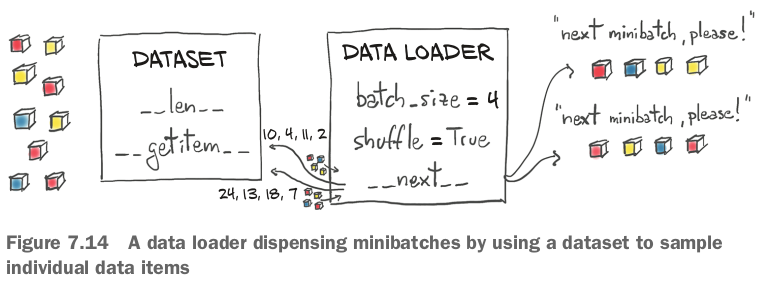

In [35]:
Image.open('img/data-loader-2020-12-27-16-23-02.png')

In [36]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = nn.Sequential(nn.Linear(3072, 512),
                     nn.Tanh(),
                     nn.Linear(512, 2),
                     nn.LogSoftmax(dim=1))
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 100
for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.341893
Epoch: 1, Loss: 0.363239
Epoch: 2, Loss: 0.289822
Epoch: 3, Loss: 0.482116
Epoch: 4, Loss: 0.215969
Epoch: 5, Loss: 0.419090
Epoch: 6, Loss: 0.345313
Epoch: 7, Loss: 0.610161
Epoch: 8, Loss: 0.386666
Epoch: 9, Loss: 0.317583
Epoch: 10, Loss: 0.467567
Epoch: 11, Loss: 0.349524
Epoch: 12, Loss: 0.589247
Epoch: 13, Loss: 0.487432
Epoch: 14, Loss: 0.298212
Epoch: 15, Loss: 0.295939
Epoch: 16, Loss: 0.384931
Epoch: 17, Loss: 0.523695
Epoch: 18, Loss: 0.356553
Epoch: 19, Loss: 0.501333
Epoch: 20, Loss: 0.414851
Epoch: 21, Loss: 0.302525
Epoch: 22, Loss: 0.350171
Epoch: 23, Loss: 0.259771
Epoch: 24, Loss: 0.235651
Epoch: 25, Loss: 0.322677
Epoch: 26, Loss: 0.285561
Epoch: 27, Loss: 0.215965
Epoch: 28, Loss: 0.235933
Epoch: 29, Loss: 0.207909
Epoch: 30, Loss: 0.100176
Epoch: 31, Loss: 0.227875
Epoch: 32, Loss: 0.177630
Epoch: 33, Loss: 0.152344
Epoch: 34, Loss: 0.307776
Epoch: 35, Loss: 0.261321
Epoch: 36, Loss: 0.101611
Epoch: 37, Loss: 0.215650
Epoch: 38, Loss: 0.084

- We can compute the accuracy of our model on the validation set in terms of the number of correct classifications over the total:

In [37]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
print("Accuracy: %f", correct / total)

Accuracy: %f 0.8085


- Not a great performance, but quite a lot better than random. overfittingだぞう！
- One rather arbitrary possibility is:

In [38]:
model = nn.Sequential(nn.Linear(3072, 1024),
                     nn.Tanh(),
                     nn.Linear(1024, 512),
                     nn.Tanh(),
                     nn.Linear(512, 128),
                     nn.Tanh(),
                     nn.Linear(128, 2),
                     nn.LogSoftmax(dim=1))

- Here we are trying to taper the number of features more gently toward the output, in the hope that **intermediate layers will do a better job of squeezing information in increasingly shorter intermediate outputs**.
- **The combination of `nn.LogSoftmax` and `nn.NLLLoss` is equivalent to using `nn.CrossEntropyLoss`**.
- Technically, `nn.NLLLoss` is the **cross entropy between the Dirac distribution, putting all mass on the target, and the predicted distribution given by the log probability inputs**. labelだから、Dirac distribution。
- In information theory, up to normalization by sample size, this cross entropy can be interpreted as a **negative log likelihood of the predicted distribution under the target distribution** as an outcome. crossだもん！
- It is quite common to drop the last `nn.LogSoftmax` layer from the network and use `nn.CrossEntropyLoss` as a loss:

In [39]:
model = nn.Sequential(nn.Linear(3072, 1024),
                     nn.Tanh(),
                     nn.Linear(1024, 512),
                     nn.Tanh(),
                     nn.Linear(512, 128),
                     nn.Tanh(),
                     nn.Linear(128, 2))
loss_fn = nn.CrossEntropyLoss()

- 注意！今the output of our model will not be interpretable as probabilities (or log probabilities).
    - We'll need to explicitly pass the output through a softmax to obtain those.
- Our fully connected model is finding a way to discriminate birds and airplanes on the training set by memorizing the training set, but performance on the validation set is not all that great, even if we choose a larger model.
- To find out how many elements are in each tensor instance, we can call the `numel` method:

In [40]:
numel_list = [p.numel()
             for p in model.parameters()
             if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [56]:
first_layer = list(model.modules())[1]
first_layer.weight.shape, first_layer.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

- こんな数のparameterの意味：our neural network won't scale very well with the number of pixels. What if we had a 1,024x1,024 RGB image?

### 7.2.7 The limits of going fully connected

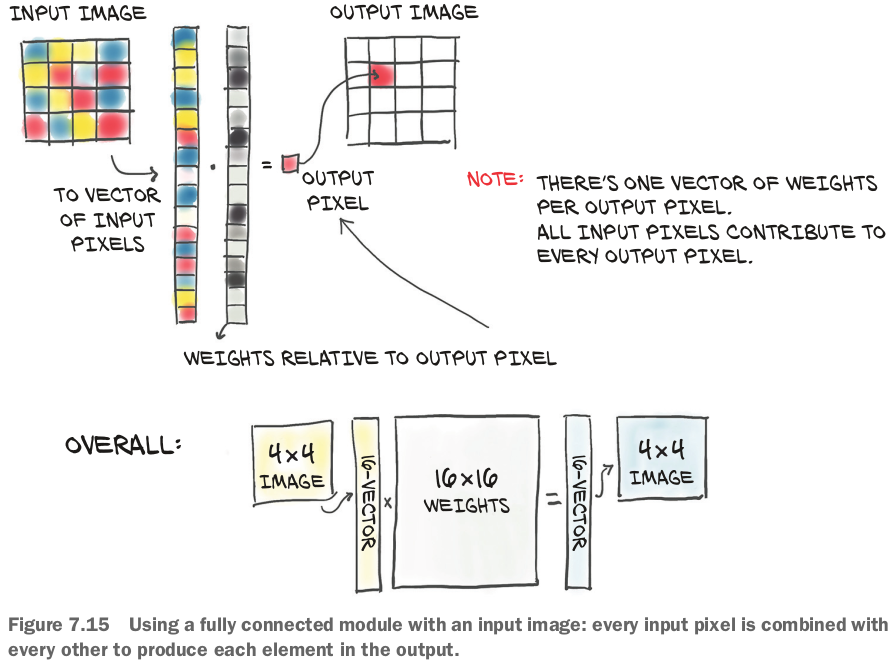

In [57]:
Image.open('img/meaning-of-using-fully-connected-module-2020-12-27-17-35-26.png')

- On one hand, we are **allowing** for the combination of any pixel with every other pixel in the image being potentially relevant for our task.
- On the other hand, we aren't utilizing the relative position of neighboring or faraway pixels, since we are treating the image as one big vector of numbers.

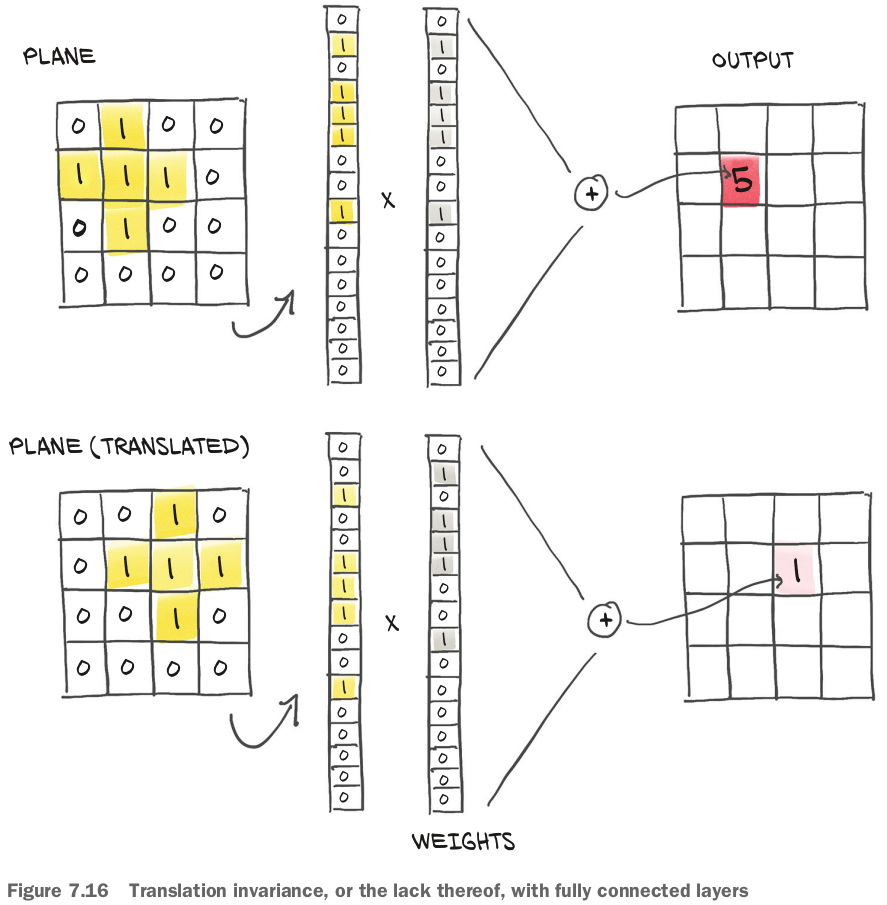

In [58]:
Image.open('img/fully-connected-layer-lacking-translation-invariance-2020-12-27-17-44-26.png')

- 結論：Due to a mismatch between our problem and our network structure, we end up overfitting our training data, rather than learning the generalized features of what we want the model to detect.